# Speaker Diarization

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is Speaker Diarization

In one audio sample, we want to know the timestamp for multiple speakers.

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `speakernet` and `vggvox-v2`.

In [2]:
model_speakernet = malaya_speech.speaker_vector.deep_model('speakernet')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

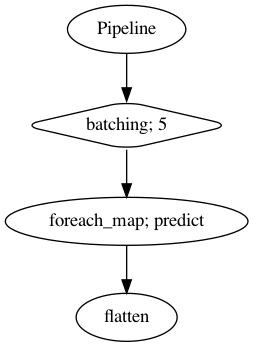

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [11]:
%%time

result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 7s, sys: 12.5 s, total: 1min 19s
Wall time: 16.7 s


dict_keys(['batching', 'predict', 'flatten'])

In [12]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

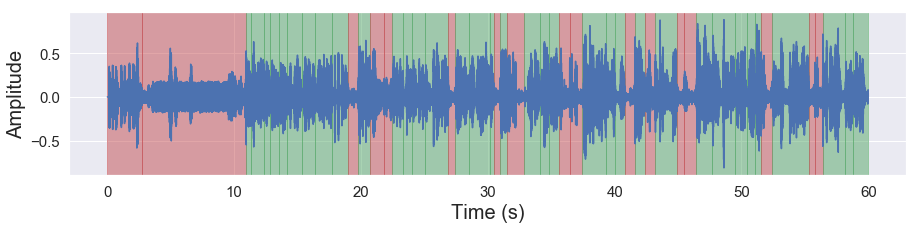

In [13]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Speaker Similarity

Simplest technique, calculate similarity,

```python
def speaker_similarity(
    vad_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    norm_function: Callable = None,
    return_embedding: bool = False,
):
    """
    Speaker diarization using L2-Norm similarity.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    speaker_change_results: List[Tuple[FRAME, float]], optional (default=None)
        results from speaker change module, must in float result.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 80%, we assumed it is from the same speaker.
    norm_function: Callable, optional(default=None)
        normalize function for speaker vectors.
    speaker_change_threshold: float, optional (default=0.5)
        in one voice activity sample can be more than one speaker, split it using this threshold.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [11]:
result_diarization_speakernet = malaya_speech.diarization.speaker_similarity(grouped_vad, model_speakernet)
result_diarization_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 1')]

In [12]:
result_diarization_vggvox2 = malaya_speech.diarization.speaker_similarity(grouped_vad, model_vggvox2)
result_diarization_vggvox2[:5]

[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 1')]

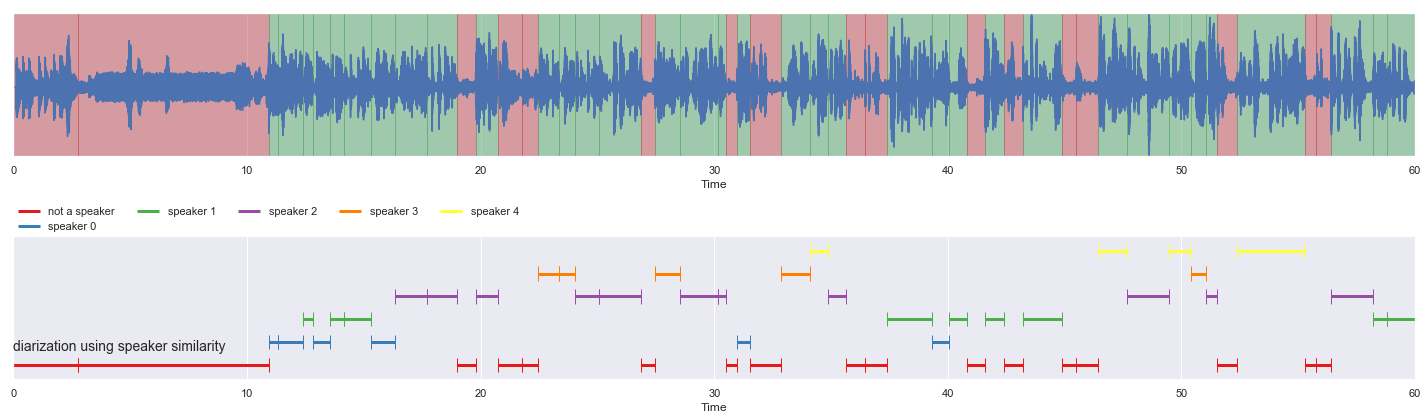

In [13]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

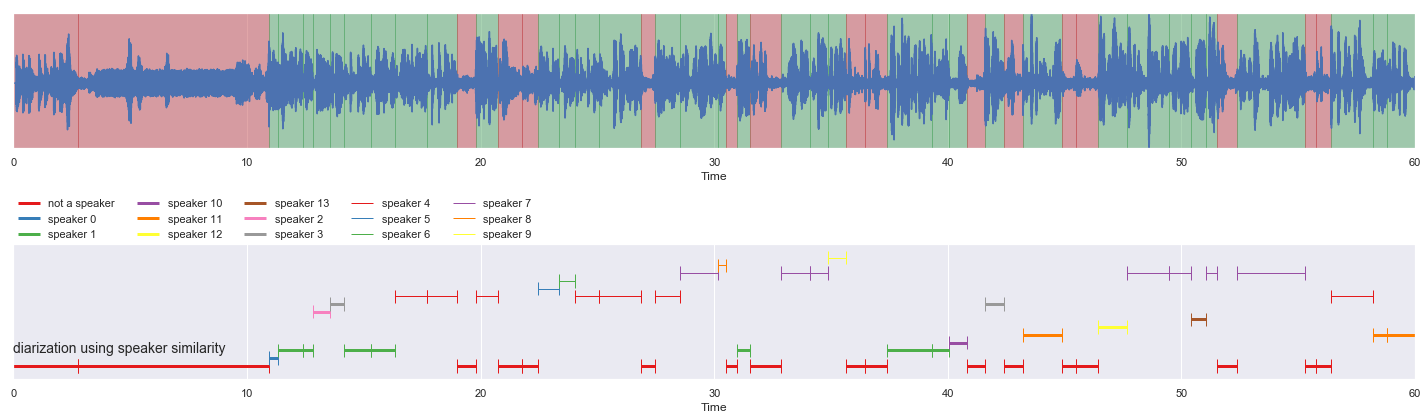

In [14]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

Problem with speaker similarity, speaker vector models are not really consistent, definition of similarity is ambigious among models, 90% similarity from model A might not be same as model B.

So, to solve this problem, we can use Affinity Propagation, a clustering technique.

### Affinity Propagation

Simply a wrapper with distance norm around sklearn,

```python
def affinity_propagation(
    vad_results,
    speaker_vector,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = 'cosine',
    damping: float = 0.8,
    preference: float = None,
    return_embedding = False,
):
    """
    Speaker diarization using sklearn Affinity Propagation.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default='cosine')
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [15]:
result_diarization_ap_speakernet = malaya_speech.diarization.affinity_propagation(grouped_vad, model_speakernet)
result_diarization_ap_speakernet[:5]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 4')]

In [16]:
result_diarization_ap_vggvox2 = malaya_speech.diarization.affinity_propagation(grouped_vad, model_vggvox2)
result_diarization_ap_vggvox2[:5]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 4')]

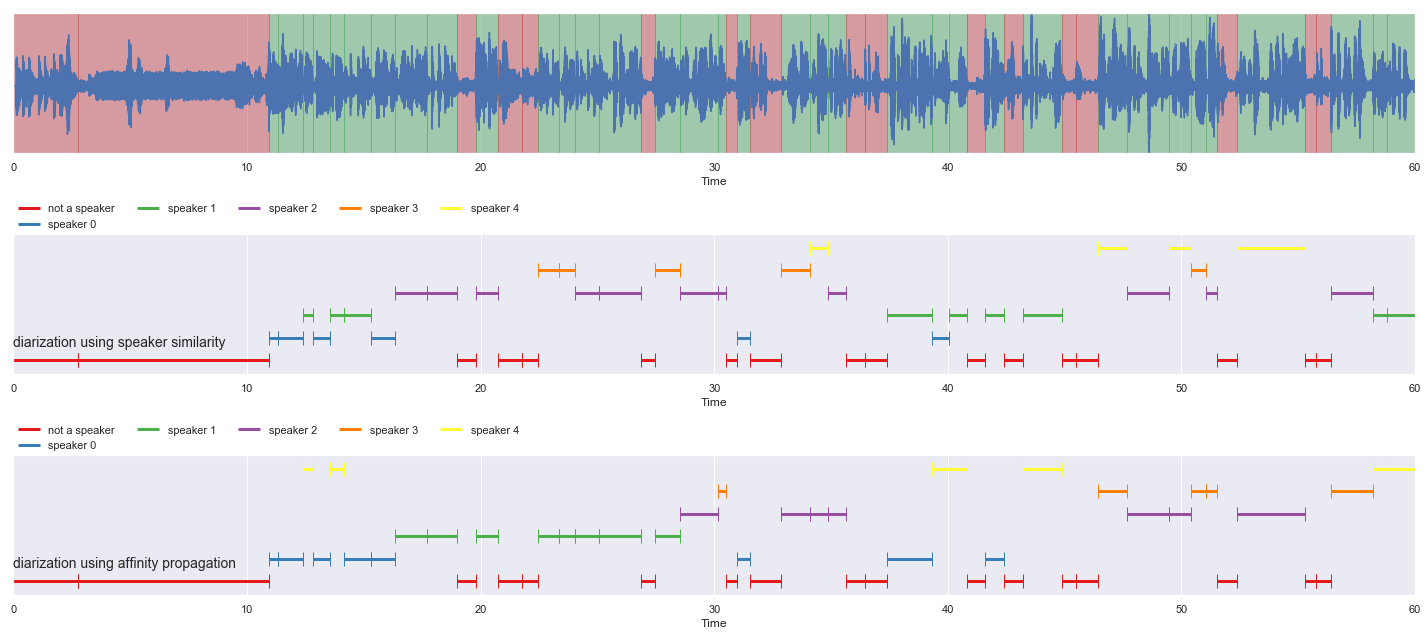

In [17]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_speakernet, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

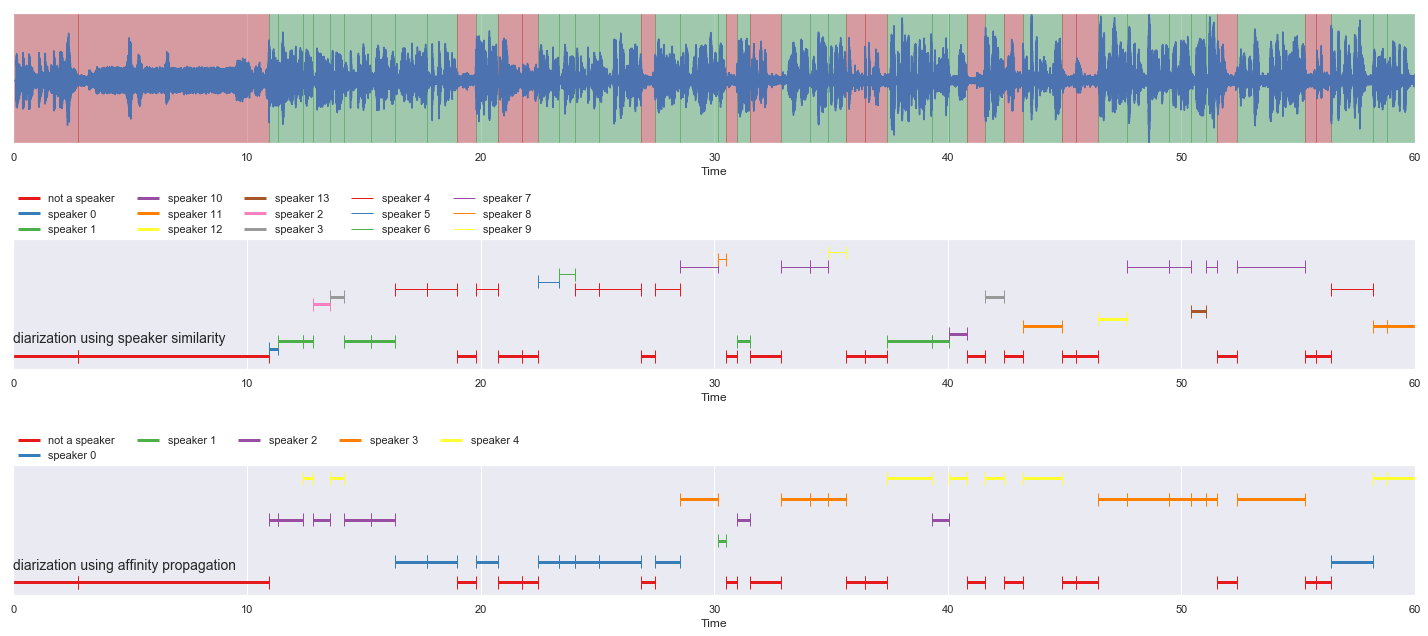

In [18]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Spectral Clustering

This is a Python re-implementation of the spectral clustering algorithm in the paper [Speaker Diarization with LSTM](https://google.github.io/speaker-id/publications/LstmDiarization/).

So, make sure you already install [spectralcluster](https://pypi.org/project/spectralcluster/),

```bash
pip install spectralcluster
```

```python
def spectral_cluster(
    vad_results,
    speaker_vector,
    min_clusters: int = None,
    max_clusters: int = None,
    p_percentile: float = 0.95,
    gaussian_blur_sigma = 1.0,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = None,
    return_embedding = False,
    **kwargs,
):
    """
    Speaker diarization using SpectralCluster, https://github.com/wq2012/SpectralCluster

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    min_clusters: int, optional (default=None)
        minimal number of clusters allowed (only effective if not None).
    max_clusters: int, optional (default=None)
        maximal number of clusters allowed (only effective if not None).
        can be used together with min_clusters to fix the number of clusters.
    gaussian_blur_sigma: float, optional (default=1.0)
        sigma value of the Gaussian blur operation.
    p_percentile: float, optional (default=0.95)
        the p-percentile for the row wise thresholding.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default=None)
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [19]:
result_diarization_sc_speakernet = malaya_speech.diarization.spectral_cluster(grouped_vad, model_speakernet,
                                                                             min_clusters = 3,
                                                                             max_clusters = 100)
result_diarization_sc_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 2')]

In [20]:
result_diarization_sc_vggvox2 = malaya_speech.diarization.spectral_cluster(grouped_vad, model_vggvox2,
                                                                          min_clusters = 3,
                                                                          max_clusters = 100)
result_diarization_sc_vggvox2[:5]

[(<malaya_speech.model.frame.Frame at 0x14fa8abd0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef77710>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15ef776d0>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x15ef77790>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x15ef777d0>, 'speaker 1')]

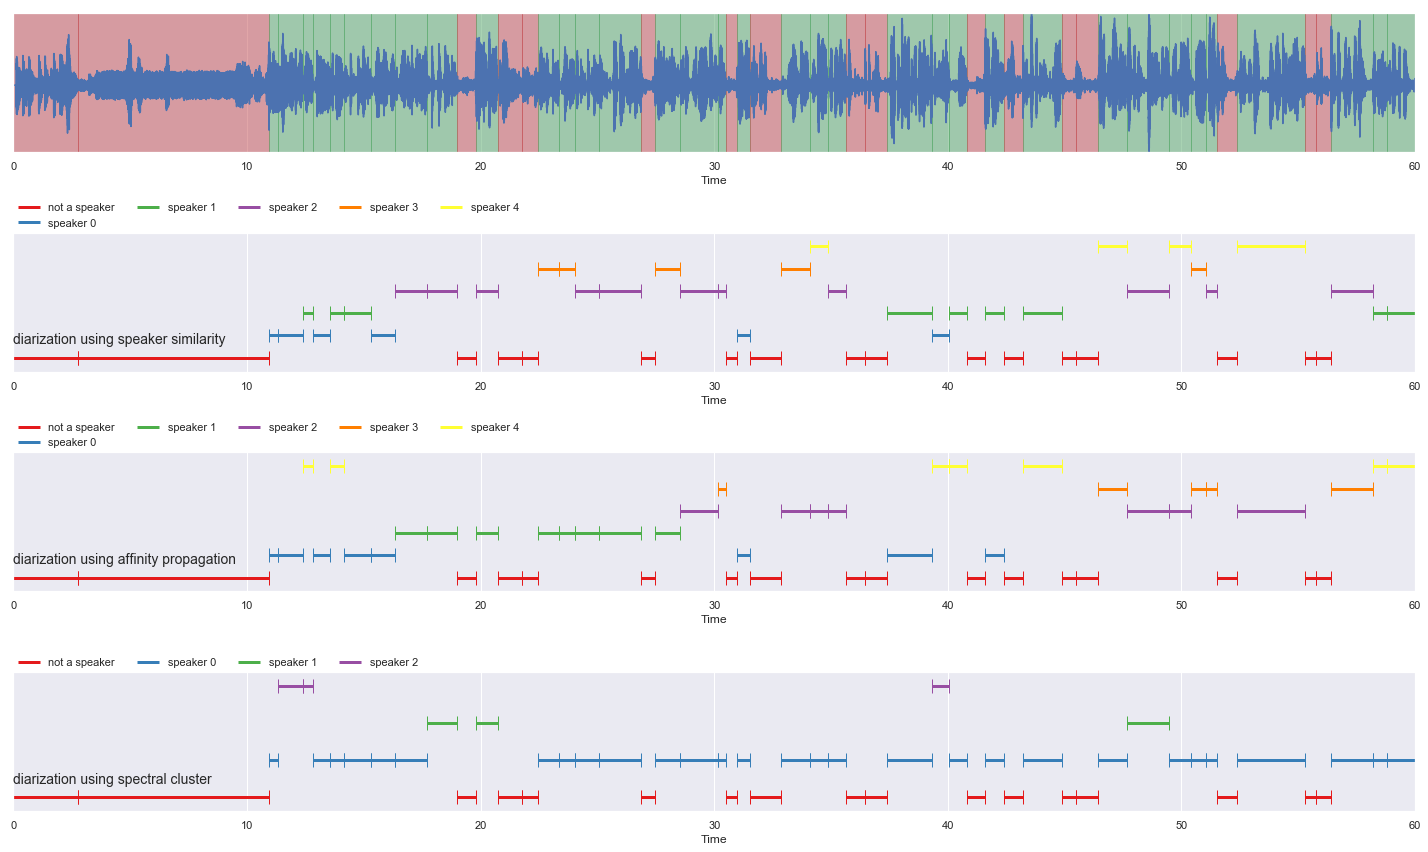

In [21]:
nrows = 4
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_speakernet, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_speakernet, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[3],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

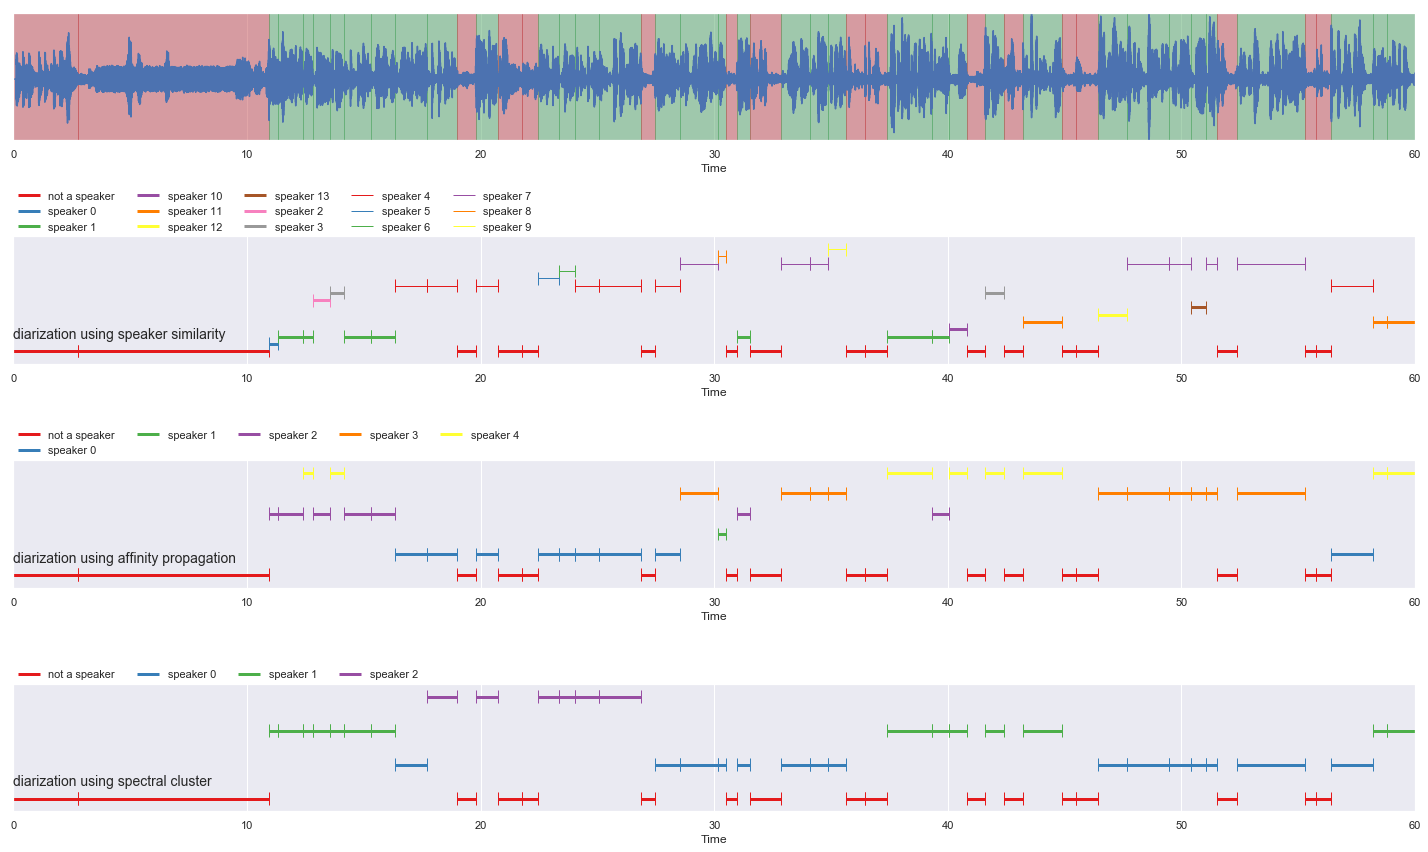

In [23]:
nrows = 4
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_vggvox2, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_vggvox2, 
                                                      'diarization using spectral cluster', ax = ax[3],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Static N speakers using sklearn clustering

Let say you already know N speakers in the audio sample and want to use Kmean algorithm for that.

```python
def n_clustering(
    vad_results,
    speaker_vector,
    model,
    norm_function: Callable = l2_normalize,
    return_embedding=False,
):
    """
    Speaker diarization using any clustering model.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    model: callable
        Prefer any sklearn unsupervised clustering model. 
        Required `fit_predict` or `apply` method.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default='cosine')
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [22]:
from sklearn.cluster import KMeans, SpectralClustering

n_speakers = 3
kmeans = KMeans(n_clusters = n_speakers)
result_diarization_kmeans_speakernet = malaya_speech.diarization.n_clustering(grouped_vad, model_speakernet,
                                                                          model = kmeans,
                                                                          norm_function = lambda x: x)
result_diarization_kmeans_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x15467f6d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1548929d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x154892990>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x154892a50>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x154892a90>, 'speaker 1')]

In [23]:
spectralclustering = SpectralClustering(n_clusters = n_speakers)
result_diarization_spectralclustering_speakernet = malaya_speech.diarization.n_clustering(grouped_vad, model_speakernet,
                                                                          model = spectralclustering,
                                                                          norm_function = lambda x: x)
result_diarization_spectralclustering_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x15467f6d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1548929d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x154892990>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x154892a50>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x154892a90>, 'speaker 0')]

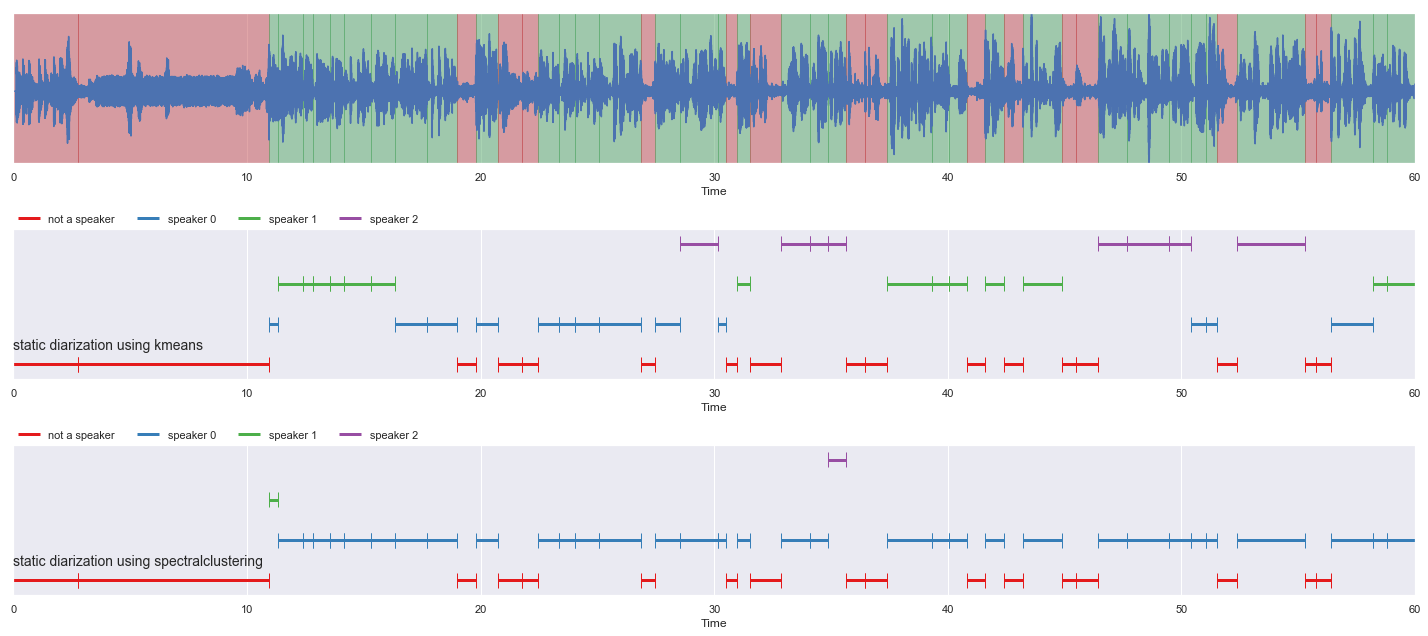

In [24]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_kmeans_speakernet, 
                                                      'static diarization using kmeans', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_spectralclustering_speakernet, 
                                                      'static diarization using spectralclustering', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Use speaker change detection

Speaker change detection is an important part of speaker diarization systems. It aims at finding the boundaries between speech turns of two different speakers. Read more about Speaker Change at https://malaya-speech.readthedocs.io/en/latest/load-speaker-change.html

In [23]:
speakernet = malaya_speech.speaker_change.deep_model('speakernet')
frames_speaker_change = list(malaya_speech.utils.generator.frames(y, 500, sr))
probs_speakernet = [(frame, speakernet.predict_proba([frame])[0, 1]) for frame in frames_speaker_change]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [24]:
nested_grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)
splitted_speakernet = malaya_speech.speaker_change.split_activities(nested_grouped_vad, probs_speakernet)

In [25]:
result_diarization_sc_splitted_speakernet = malaya_speech.diarization.spectral_cluster(splitted_speakernet, 
                                                                                       model_speakernet,
                                                                                       min_clusters = 3,
                                                                                       max_clusters = 100)
result_diarization_sc_splitted_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x15d150c50>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15d150f50>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15d150490>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15d1503d0>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x15d150290>, 'speaker 2')]

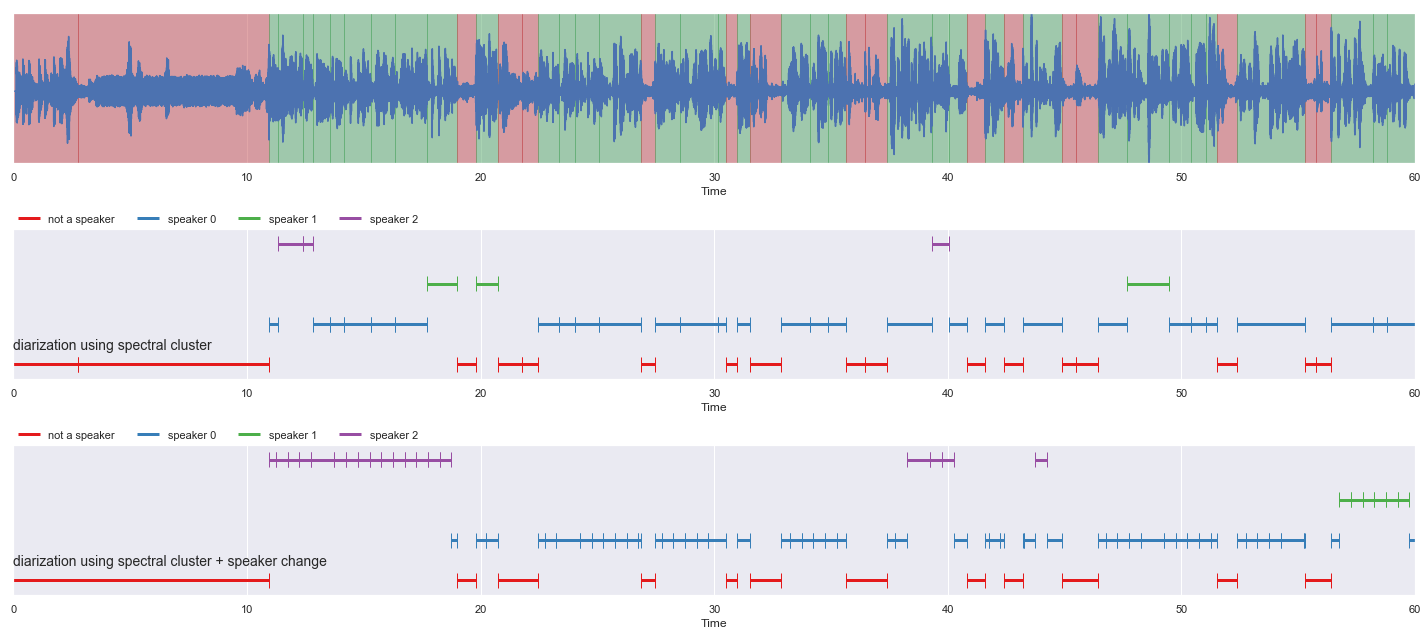

In [26]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_splitted_speakernet, 
                                                      'diarization using spectral cluster + speaker change', 
                                                      ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### How to get timestamp

1. Group multiple frames based on label, this can achieve using `malaya_speech.group.group_frames`.

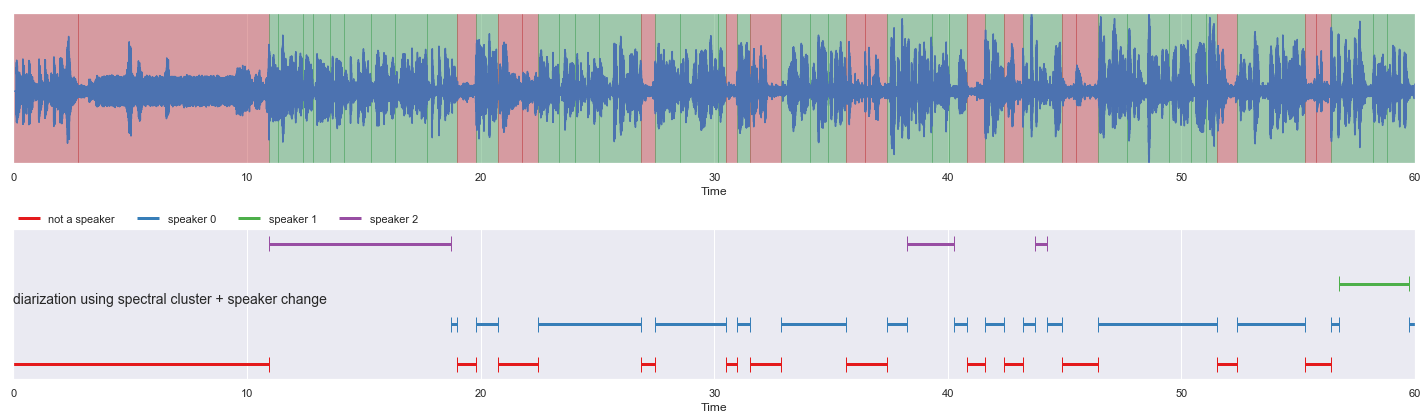

In [27]:
grouped = malaya_speech.group.group_frames(result_diarization_sc_splitted_speakernet)

nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(grouped, 
                                                      'diarization using spectral cluster + speaker change', 
                                                      ax = ax[1],
                                                     x_text = 0.01, y_text = 0.5)
fig.tight_layout()
plt.show()

2. Inspect grouped variable.

In [28]:
grouped[0]

(<malaya_speech.model.frame.Frame at 0x157101f90>, 'not a speaker')

`malaya_speech.model.frame.Frame` stores `timestamp` and `duration` attributes.

In [29]:
grouped[0][0].timestamp, grouped[0][0].duration, grouped[0][1]

(0.0, 10.95000000000002, 'not a speaker')

In [30]:
grouped[1][0].timestamp, grouped[1][0].duration, grouped[1][1]

(10.949999999999958, 7.800000000000042, 'speaker 2')

### Reference

1. Neural speech turn segmentation and affinity propagation for speaker diarization, Ruiqing Yin, Herve Bredin, Claude Barras, https://www.isca-speech.org/archive/Interspeech_2018/pdfs/1750.pdf
2. Spectral Clustering, https://github.com/wq2012/SpectralCluster
3. The Singaporean White Boy - The Shan and Rozz Show: EP7, https://www.youtube.com/watch?v=HylaY5e1awo&t=2s&ab_channel=Clicknetwork